In [1]:
remotes::install_github("peeter-t2/digar.txts",lib="R_pckg/",upgrade="never")
library(digar.txts,lib.loc="R_pckg/")

* checking for file ‘/tmp/RtmpaWWyrI/remotes31144d27bb85/peeter-t2-digar.txts-b87e10a/DESCRIPTION’ ... OK
* preparing ‘digar.txts’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘digar.txts_0.0.0.9100.tar.gz’
Warning in sprintf(gettext(fmt, domain = domain), ...) :
  one argument not used by format 'invalid uid value replaced by that for user 'nobody''



Loading required package: data.table



In [2]:
library(tidyverse)
library(igraph)
install.packages('tidytext', lib='~/R_pckg')
library(tidytext, lib.loc='~/R_pckg')
install.packages('ggraph', lib='~/R_pckg')
library(ggraph, lib.loc='~/R_pckg')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose

In [3]:
all_issues <- get_digar_overview()

[1] "Issue metadata read"


In [4]:
stopsonad <- read.table("estonian-stopwords-lemmas.txt", header = TRUE, sep = "\t", encoding = "UTF-8", stringsAsFactors = T)

In [5]:
rootsi_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="estdagbladet" | keyid=="eestiteatajastock" | keyid=="stockholmstid" | keyid=="teatajapoliit" | keyid=="valiseesti")

In [6]:
searchterm <- "balti"
searchfile <- "balti_lemmad_rootsi.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, rootsi_ajalehed, searchtype="lemmas", source="pages")

In [7]:
texts2 <- fread("balti_lemmad_rootsi.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts2[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta2 <- texts2 %>% select(id, DocumentID) %>% left_join(rootsi_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [8]:
rootsi_ngrammid <- get_concordances(searchterm=searchterm,texts=texts2,before=50,after=50,txt="lemmas",id="id")

In [9]:
rootsi_concs <- rootsi_ngrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(rootsi_concs, "rootsi_ngrammid.txt", sep="\t", quote = F, row.names = F)

In [10]:
bigrams_separated_rootsi <- rootsi_concs %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [11]:
bigrams_filtered_rootsi <- bigrams_separated_rootsi %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [12]:
bigram_counts_rootsi <- bigrams_filtered_rootsi %>% 
  count(word1, word2, sort = TRUE)

In [84]:
bigram_graph_rootsi <- bigram_counts_rootsi %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

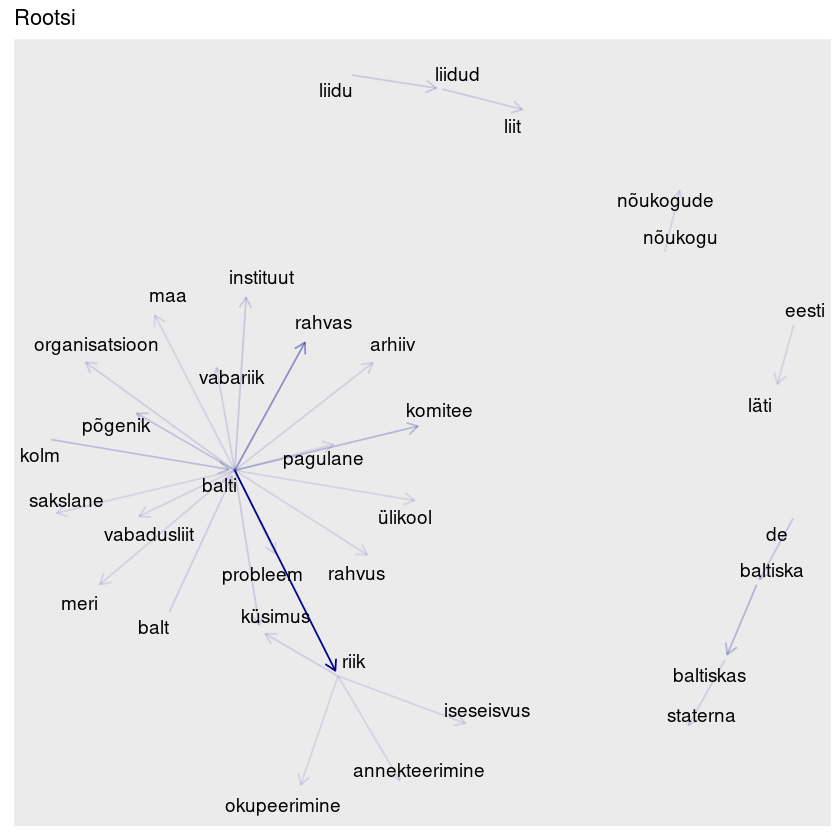

In [85]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_rootsi, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("Rootsi")

In [55]:
#suurendan tähemärkide vahemikku 100 peale
rootsi_ngrammid2 <- get_concordances(searchterm=searchterm,texts=texts2,before=100,after=100,txt="lemmas",id="id")

In [56]:
rootsi_concs2 <- rootsi_ngrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(rootsi_concs2, "rootsi_ngrammid_2.txt", sep="\t", quote = F, row.names = F)

In [57]:
bigrams_separated_rootsi2 <- rootsi_concs2 %>%
  unnest_tokens(bigram, context, token = "skip_ngrams", n = 3, k = 3) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

bigrams_separated_rootsi2_1 <- na.omit(bigrams_separated_rootsi2)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 8274887 rows [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772895 rows [1, 22, 43, 64, 85, 106, 127, 148, 168, 186, 201, 212, 219, 223, 225, 226, 247, 268, 289, 310, ...].”


In [58]:
bigrams_filtered_rootsi2 <- bigrams_separated_rootsi2_1 %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [59]:
bigram_counts_rootsi2 <- bigrams_filtered_rootsi2 %>% 
  count(word1, word2, sort = TRUE)

In [60]:
bigram_graph_rootsi2 <- bigram_counts_rootsi2 %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

In [61]:
bigram_graph_rootsi2

IGRAPH f1f81e2 DN-- 26 30 -- 
+ attr: name (v/c), n (e/n)
+ edges from f1f81e2 (vertex names):
 [1] balti   ->riik           balti   ->rahvas         baltiska->baltiskas     
 [4] balti   ->komitee        eesti   ->balti          balti   ->küsimus       
 [7] kolm    ->balti          de      ->baltiska       de      ->baltiskas     
[10] balti   ->põgenik        balti   ->balti          balti   ->esindaja      
[13] balti   ->instituut      balti   ->eesti          kolm    ->riik          
[16] rootsi  ->balti          balti   ->organisatsioon balti   ->nõukogu       
[19] riik    ->küsimus        balt    ->balti          balti   ->rootsi        
[22] liidu   ->liidud         andma   ->balti          balti   ->vabariik      
+ ... omitted several edges

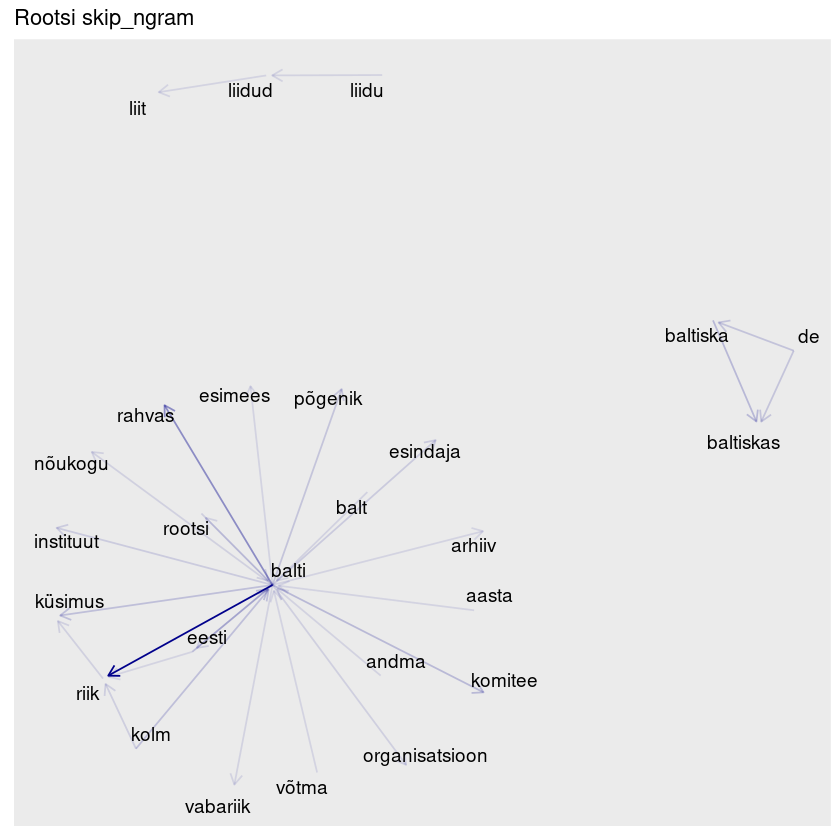

In [63]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_rootsi2, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("Rootsi skip_ngram")

In [64]:
kanada_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestlane" | keyid=="voitleja")

In [65]:
searchfile <- "balti_lemmad_kanada.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, kanada_ajalehed, searchtype="lemmas", source="pages")

In [66]:
texts3 <- fread("balti_lemmad_kanada.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts3[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta3 <- texts3 %>% select(id, DocumentID) %>% left_join(kanada_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [67]:
kanada_ngrammid <- get_concordances(searchterm=searchterm,texts=texts3,before=50,after=50,txt="lemmas",id="id")

In [68]:
kanada_concs <- kanada_ngrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(kanada_concs, "kanada_ngrammid.txt", sep="\t", quote = F, row.names = F)

In [69]:
bigrams_separated_kanada <- kanada_concs %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [70]:
bigrams_filtered_kanada <- bigrams_separated_kanada %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [71]:
bigram_counts_kanada <- bigrams_filtered_kanada %>% 
  count(word1, word2, sort = TRUE)

In [72]:
bigram_graph_kanada <- bigram_counts_kanada %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

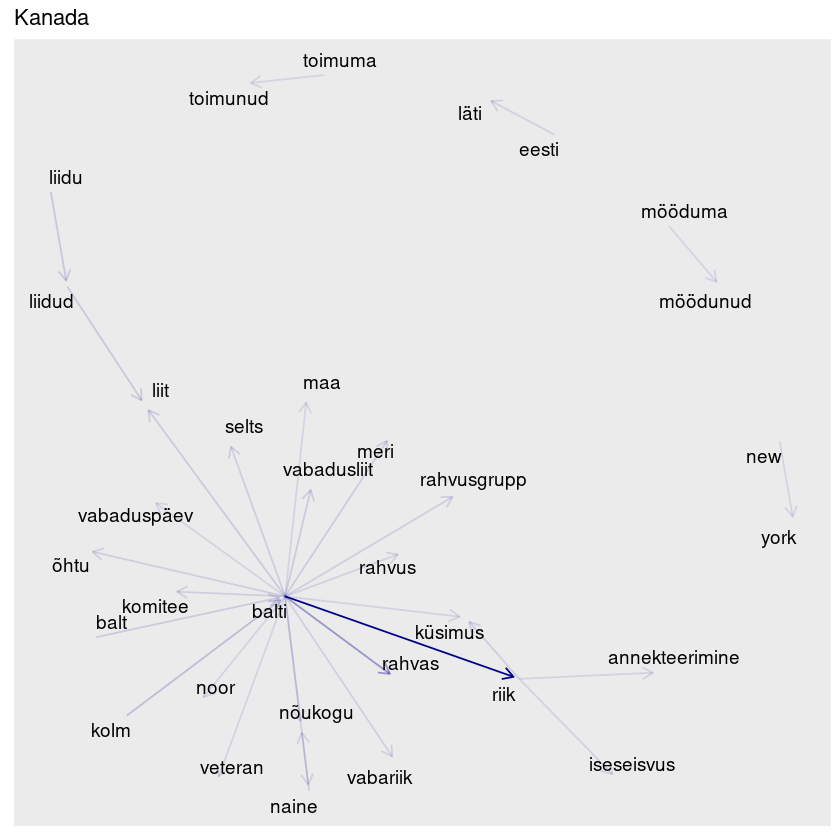

In [73]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_kanada, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("Kanada")

In [74]:
usa_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestisona")

In [75]:
searchfile <- "balti_lemmad_usa.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, usa_ajalehed, searchtype="lemmas", source="pages")

In [76]:
texts4 <- fread("balti_lemmad_usa.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts4[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta4 <- texts4 %>% select(id, DocumentID) %>% left_join(usa_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [77]:
usa_ngrammid <- get_concordances(searchterm=searchterm,texts=texts4,before=50,after=50,txt="lemmas",id="id")

In [78]:
usa_concs <- usa_ngrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(usa_concs, "usa_ngrammid.txt", sep="\t", quote = F, row.names = F)

In [79]:
bigrams_separated_usa <- usa_concs %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [80]:
bigrams_filtered_usa <- bigrams_separated_usa %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [81]:
bigram_counts_usa <- bigrams_filtered_usa %>% 
  count(word1, word2, sort = TRUE)

In [82]:
bigram_graph_usa <- bigram_counts_usa %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

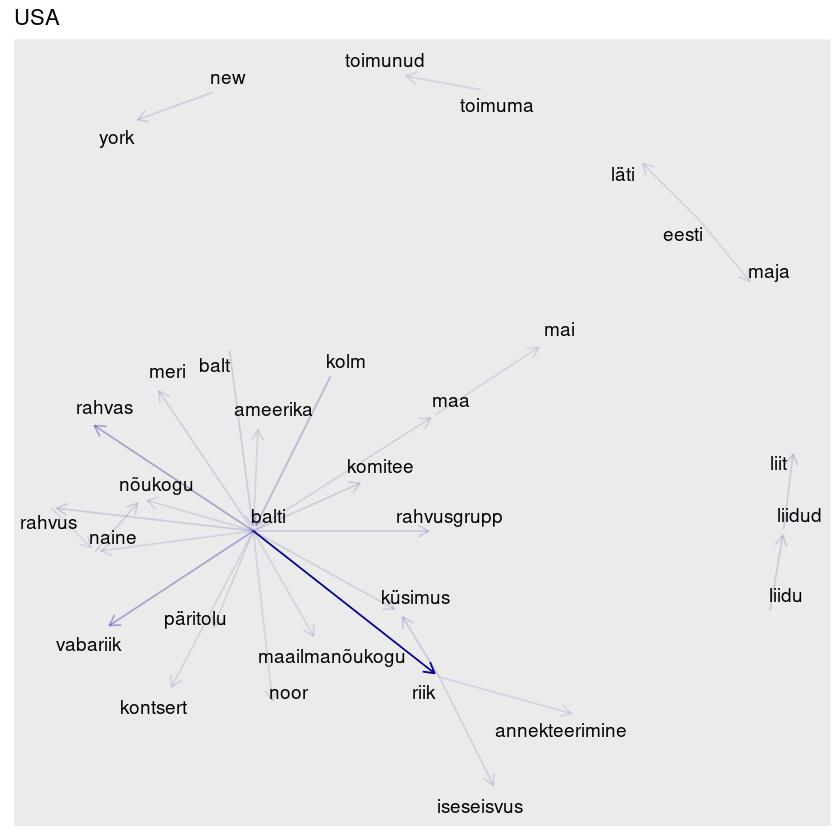

In [83]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_usa, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("USA")